# Individual Assignment 
## RL - CentraleSupélec - 2024
### Student: Gabriel Ben Zenou

## Reinforce Monte Carlo

Here we implement the Reinforce Monte Carlo algorithm to solve the flappy bird environment from OpenAI Gym. We decided to try using a neural network to approximate the policy function in order to be able to reach good performance for the screen environment without computing the distance. However, we were not able to make it work. We thus used it for the classic environment. 

In [214]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from collections import deque
from pdb import set_trace

class Policy(nn.Module):
    def __init__(self, device, state_size=2, action_size=2, hidden_size=4):
        super(Policy, self).__init__()
        self.device = device
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size) 
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = np.array(state)
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)

def reinforce(policy, env, optimizer, display=True, n_episodes=1000, max_t=100, gamma=1, print_every=100, threshold=70.0):
    scores_deque = deque(maxlen=100)
    mean_scores = []
    scores = []
    for e in range(1, n_episodes):
        saved_log_probs = []
        rewards = []
        state, _ = env.reset()

        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _, _ = env.step(action)
            rewards.append(reward)
            if done:
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        discounts = [gamma ** i for i in range(len(rewards) + 1)]
        R = sum([a * b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        mean_scores.append(np.mean(scores_deque))
        if display:
            if e % print_every == 0:
                print('Episode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_deque)))
            if mean_scores[-1] >= threshold:
                print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e, np.mean(scores_deque)))
                break
    return scores, mean_scores

Let's try it out!

In [215]:
import gymnasium as gym
import torch
import torch.optim as optim
from matplotlib import pyplot as plt

import text_flappy_bird_gym

env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MC_policy = Policy(device).to(device)
optimizer = optim.Adam(MC_policy.parameters(), lr=1e-2)
scores, mean_scores = reinforce(MC_policy, env, optimizer, n_episodes=4000)

env.close()

Episode 100	Average Score: 8.30
Episode 200	Average Score: 15.89
Episode 300	Average Score: 22.09
Episode 400	Average Score: 15.33
Episode 500	Average Score: 31.56
Episode 600	Average Score: 42.30
Episode 700	Average Score: 14.80
Episode 800	Average Score: 13.30
Episode 900	Average Score: 16.91
Episode 1000	Average Score: 47.98
Episode 1100	Average Score: 64.01
Environment solved in 1124 episodes!	Average Score: 70.27


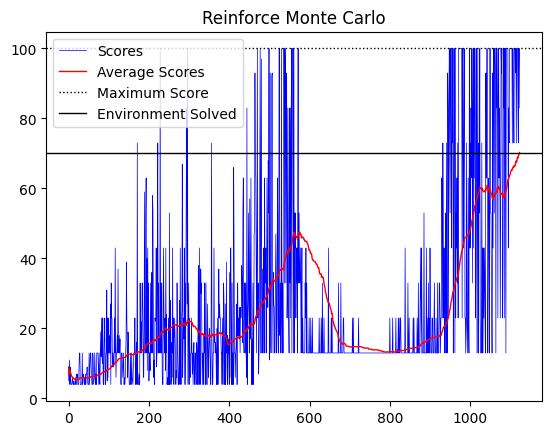

In [216]:
# Plotting scores
plt.plot(scores, color='blue', linewidth=0.5, label='Scores')
plt.plot(mean_scores, color='red', linewidth=1, label='Average Scores')
plt.axhline(y=100, color='black', linestyle='dotted', linewidth=1, label='Maximum Score')
plt.axhline(y=70, color='black', linewidth=1, label='Environment Solved')
plt.legend()
plt.title('Reinforce Monte Carlo')
plt.show()

We succeeded in training an agent able to play the game. Let's see how well it performs in the conditions it was trained in and in new conditions.

In [224]:
import gymnasium as gym
from tqdm import tqdm

# Define the different sets of parameters
parameters = [
    {'height': 15, 'width': 20, 'pipe_gap': 4},
    {'height': 10, 'width': 15, 'pipe_gap': 4},
    {'height': 30, 'width': 40, 'pipe_gap': 4},
    {'height': 15, 'width': 20, 'pipe_gap': 3},
    {'height': 10, 'width': 15, 'pipe_gap': 3},
    {'height': 30, 'width': 40, 'pipe_gap': 3},
    {'height': 15, 'width': 20, 'pipe_gap': 5},
    {'height': 10, 'width': 15, 'pipe_gap': 5},
    {'height': 30, 'width': 40, 'pipe_gap': 5}
    # Add more sets of parameters as needed
]
n_runs = 50

# Iterate over the sets of parameters
for params in parameters:
    # initiate environment
    env = gym.make('TextFlappyBird-v0', height=params['height'], width=params['width'], pipe_gap=params['pipe_gap'])
    total_reward = 0

    # Run 50 episodes
    for episode in tqdm(range(n_runs)):
        state, _ = env.reset()
        reward_sum = 0

        # iterate
        while True:
            # Select next action
            action, log_prob = MC_policy.act(state)

            # Apply action and return new observation of the environment
            state, reward, done, _, _ = env.step(action)
            reward_sum += reward

            # If player is dead, break
            if done:
                break

        total_reward += reward_sum

    # Calculate the average reward
    average_reward = total_reward / n_runs

    # Print the average reward for the current set of parameters
    print(f"Average reward for height={params['height']}, width={params['width']}, pipe_gap={params['pipe_gap']}: {average_reward}")


100%|██████████| 50/50 [00:10<00:00,  4.92it/s]


Average reward for height=15, width=20, pipe_gap=4: 208.6


100%|██████████| 50/50 [00:07<00:00,  6.75it/s]


Average reward for height=10, width=15, pipe_gap=4: 158.98


100%|██████████| 50/50 [00:14<00:00,  3.45it/s]


Average reward for height=30, width=40, pipe_gap=4: 285.0


100%|██████████| 50/50 [00:01<00:00, 27.85it/s]


Average reward for height=15, width=20, pipe_gap=3: 35.2


100%|██████████| 50/50 [00:01<00:00, 30.21it/s]


Average reward for height=10, width=15, pipe_gap=3: 34.0


100%|██████████| 50/50 [00:04<00:00, 11.47it/s]


Average reward for height=30, width=40, pipe_gap=3: 91.0


100%|██████████| 50/50 [00:48<00:00,  1.03it/s]


Average reward for height=15, width=20, pipe_gap=5: 1017.2


100%|██████████| 50/50 [00:41<00:00,  1.20it/s]


Average reward for height=10, width=15, pipe_gap=5: 892.48


100%|██████████| 50/50 [00:56<00:00,  1.14s/it]

Average reward for height=30, width=40, pipe_gap=5: 1201.76


As exepected, the agent performs well in the conditions it was trained in. It performs even better in conditions where the pipe gap is larger and the sight is wider. However, for a smaller pipe gap, the performance decrease drastically, the game becoming harder and the agent not being able to adapt to these new conditions.

The above results are obtained in the good case scenario. The algorithm is not stable and the results can vary a lot. \\
We thus run the following parts to get results on 50 episodes.

In [151]:
from tqdm import tqdm
scores = []
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for i in tqdm(range(50)):
    policy = Policy(device).to(device)
    optimizer = optim.Adam(policy.parameters(), lr=1e-2)
    _, mean_scores = reinforce(policy, env, optimizer, display=False, n_episodes=2000, threshold=50.0)
    scores.append(mean_scores[-1])
env.close()


100%|██████████| 50/50 [1:10:52<00:00, 85.05s/it] 


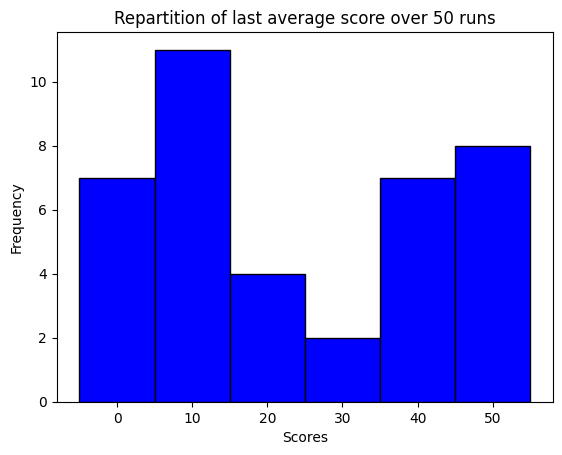

In [159]:
# Plotting scores
plt.hist(scores, bins=range(-5, 60, 10), color='blue', edgecolor='black')
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Repartition of last average score over 50 runs')
plt.show()

Although the agent often seems to be able to succeed in playing the game, it is not able to do so in a stable way. The results are not consistent and the agent often fails to correctly learn how to play.

## SARSA($\lambda$)

We here implement the SARSA($\lambda$) algorithm to solve the flappy bird environment from OpenAI Gym. This time, we decided not to use a NN to approximate the Q function, as it was not working well in the previous case. We will use a simple Q table instead.

In [225]:
from collections import defaultdict
import numpy as np

def argmax(q_values):
    top = float("-inf")
    ties = []
    for i in range(len(q_values)):
        if q_values[i] > top:
            top = q_values[i]
            ties = []
        if q_values[i] == top:
            ties.append(i)
    return np.random.choice(ties)

class SarsaLambda():
    def __init__(self, device, gamma=1, lambda_=0.9, alpha=0.1, epsilon=0.2):
        self.device = device
        self.gamma = gamma
        self.lambda_ = lambda_
        self.alpha = alpha
        self.epsilon = epsilon
        self.Q = np.zeros((14,25,2))
        self.eligibility = np.zeros((14,25,2))
    
    def act(self, state, e):
        x,y = state
        y += 11
        if e<4000 and np.random.rand() < self.epsilon:
            return np.random.choice(2)
        else:
            action = argmax(self.Q[x][y])
        return action
    
    def update(self, state, action, reward, next_state, next_action, done):
        x,y = state
        y += 11
        Q = self.Q[x][y][action]
        next_x,next_y = next_state
        next_y += 11
        Q_next = self.Q[next_x][next_y][next_action]
        
        delta = reward + self.gamma * Q_next - Q
        self.eligibility[x][y][action] += 1 # Accumulating traces
        # self.eligibility[state][action] = 1 # Replacing traces
        # self.eligibility[state][action] = 1 + self.eligibility[state][action] * self.gamma * (1-self.alpha) # Dutch traces

        self.Q += self.alpha * delta * self.eligibility
        self.eligibility *= self.gamma * self.lambda_

def sarsa_lambda(agent, env, display=True, n_episodes=1000, max_t=100, gamma=1, lambda_=0.9, alpha=0.1, print_every=100, threshold=70.0):
    scores_deque = deque(maxlen=100)
    mean_scores = []
    scores = []
    for e in range(1, n_episodes):
        state, _ = env.reset()
        action = agent.act(state, e)
        agent.eligibility = np.zeros((14,25,2))
        rewards = []
        for t in range(max_t):
            next_state, reward, done, _, _ = env.step(action)
            next_action = agent.act(next_state, e)
            agent.update(state, action, reward, next_state, next_action, done)
            state = next_state
            action = next_action
            rewards.append(reward)
            if done:
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        mean_scores.append(np.mean(scores_deque))
        if display:
            if e % print_every == 0:
                print('Episode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_deque)))
            if mean_scores[-1] >= threshold:
                print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e, np.mean(scores_deque)))
                break
    return scores, mean_scores

Let's find the best hyperparameters for the agent to perform!

In [183]:
# Define the range of values for each parameter
epsilon_values = [0, 0.1, 0.2, 0.3]
alpha_values = [0.1, 0.2, 0.3]
lambda_values = [0.7, 0.8, 0.9]
gamma_values = [0.9, 1.0]

best_average_score = -float('inf')
best_parameters = {}
parameters_scores = {}

env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

# Iterate over all combinations of parameter values
for epsilon in epsilon_values:
    parameters_scores[epsilon] = {}
    for alpha in alpha_values:
        parameters_scores[epsilon][alpha] = {}
        for lambda_ in lambda_values:
            parameters_scores[epsilon][alpha][lambda_] = {}
            for gamma in gamma_values:
                print('Epsilon:', epsilon, 'Alpha:', alpha, 'Lambda:', lambda_, 'Gamma:', gamma)
                # Create a new agent with the current parameter values
                sarsa_lambda_agent = SarsaLambda(device, epsilon=epsilon, alpha=alpha, lambda_=lambda_, gamma=gamma)
                
                # Run the SARSA(λ) algorithm with the current agent and environment
                scores, mean_scores = sarsa_lambda(sarsa_lambda_agent, env, n_episodes=6000, display=False)
                parameters_scores[epsilon][alpha][lambda_][gamma] = mean_scores
                
                # Calculate the average score
                average_score = np.mean(mean_scores)
                
                # Check if the current combination of parameters gives a better average score
                if average_score > best_average_score:
                    best_average_score = average_score
                    best_parameters = {
                        'epsilon': epsilon,
                        'alpha': alpha,
                        'lambda_': lambda_,
                        'gamma': gamma
                    }

# Print the best combination of parameters and the corresponding average score
print('Best Parameters:', best_parameters)
print('Best Average Score:', best_average_score)

env.close()


Epsilon: 0 Alpha: 0.1 Lambda: 0.7 Gamma: 0.9
Epsilon: 0 Alpha: 0.1 Lambda: 0.7 Gamma: 1.0
Epsilon: 0 Alpha: 0.1 Lambda: 0.8 Gamma: 0.9
Epsilon: 0 Alpha: 0.1 Lambda: 0.8 Gamma: 1.0
Epsilon: 0 Alpha: 0.1 Lambda: 0.9 Gamma: 0.9
Epsilon: 0 Alpha: 0.1 Lambda: 0.9 Gamma: 1.0
Epsilon: 0 Alpha: 0.2 Lambda: 0.7 Gamma: 0.9
Epsilon: 0 Alpha: 0.2 Lambda: 0.7 Gamma: 1.0
Epsilon: 0 Alpha: 0.2 Lambda: 0.8 Gamma: 0.9
Epsilon: 0 Alpha: 0.2 Lambda: 0.8 Gamma: 1.0
Epsilon: 0 Alpha: 0.2 Lambda: 0.9 Gamma: 0.9
Epsilon: 0 Alpha: 0.2 Lambda: 0.9 Gamma: 1.0
Epsilon: 0 Alpha: 0.3 Lambda: 0.7 Gamma: 0.9
Epsilon: 0 Alpha: 0.3 Lambda: 0.7 Gamma: 1.0
Epsilon: 0 Alpha: 0.3 Lambda: 0.8 Gamma: 0.9
Epsilon: 0 Alpha: 0.3 Lambda: 0.8 Gamma: 1.0
Epsilon: 0 Alpha: 0.3 Lambda: 0.9 Gamma: 0.9
Epsilon: 0 Alpha: 0.3 Lambda: 0.9 Gamma: 1.0
Epsilon: 0.1 Alpha: 0.1 Lambda: 0.7 Gamma: 0.9
Epsilon: 0.1 Alpha: 0.1 Lambda: 0.7 Gamma: 1.0
Epsilon: 0.1 Alpha: 0.1 Lambda: 0.8 Gamma: 0.9
Epsilon: 0.1 Alpha: 0.1 Lambda: 0.8 Gamma: 1.0
Ep

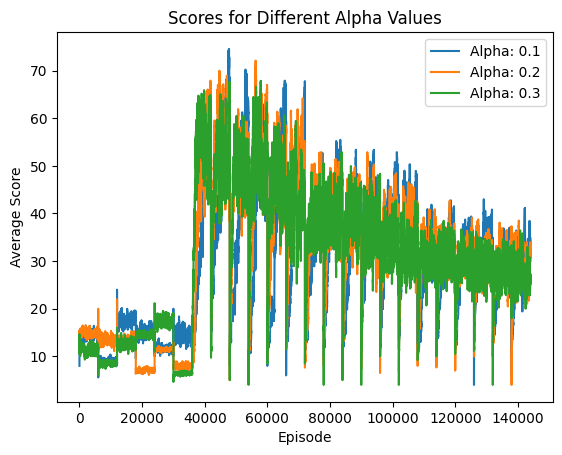

In [189]:
# Create a dictionary to store the scores for each alpha
alpha_scores = {}
for alpha in alpha_values:
    alpha_scores[alpha] = []
    for epsilon in epsilon_values:
        for lambda_ in lambda_values:
            for gamma in gamma_values:
                alpha_scores[alpha].extend(parameters_scores[epsilon][alpha][lambda_][gamma])

# Plot the scores for each alpha
for alpha, scores in alpha_scores.items():
    plt.plot(scores, label=f'Alpha: {alpha}')

# Add labels and title to the plot
plt.xlabel('Episode')
plt.ylabel('Average Score')
plt.title('Scores for Different Alpha Values')

# Add legend to the plot
plt.legend()

# Show the plot
plt.show()


An $\alpha$ equal to 0.1 seems to be the one giving the best results, although $\alpha = 0.2$ and $\alpha = 0.3$ may also be good choices. 

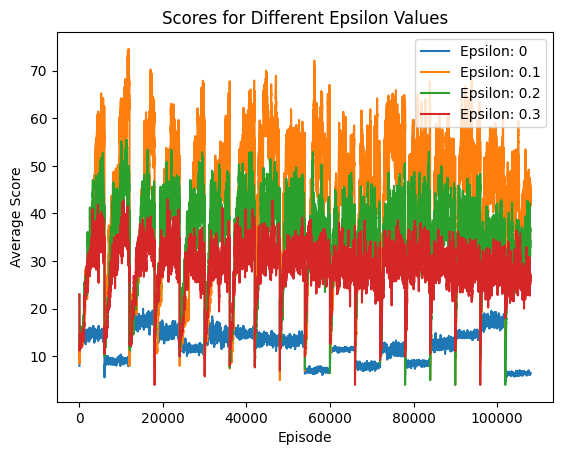

In [193]:
# Create a dictionary to store the scores for each alpha
epsilon_scores = {}
for epsilon in epsilon_values:
    epsilon_scores[epsilon] = []
    for alpha in alpha_values:
        for lambda_ in lambda_values:
            for gamma in gamma_values:
                epsilon_scores[epsilon].extend(parameters_scores[epsilon][alpha][lambda_][gamma])

# Plot the scores for each alpha
for epsilon, scores in epsilon_scores.items():
    plt.plot(scores, label=f'Epsilon: {epsilon}')

# Add labels and title to the plot
plt.xlabel('Episode')
plt.ylabel('Average Score')
plt.title('Scores for Different Epsilon Values')

# Add legend to the plot
plt.legend()

# Show the plot
plt.show()


$\epsilon = 0.1$ is from far the best choice for the exploration rate.

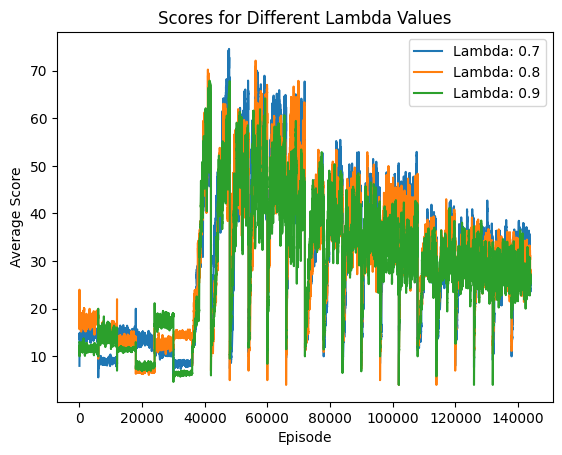

In [195]:
# Create a dictionary to store the scores for each alpha
lambda_scores = {}
for lambda_ in lambda_values:
    lambda_scores[lambda_] = []
    for epsilon in epsilon_values:
        for alpha in alpha_values:
            for gamma in gamma_values:
                lambda_scores[lambda_].extend(parameters_scores[epsilon][alpha][lambda_][gamma])

# Plot the scores for each alpha
for lambda_, scores in lambda_scores.items():
    plt.plot(scores, label=f'Lambda: {lambda_}')

# Add labels and title to the plot
plt.xlabel('Episode')
plt.ylabel('Average Score')
plt.title('Scores for Different Lambda Values')

# Add legend to the plot
plt.legend()

# Show the plot
plt.show()


As for the choice of the alpha, we will decide to privilege the best performance obtained and will thus choose $\lambda = 0.7$.

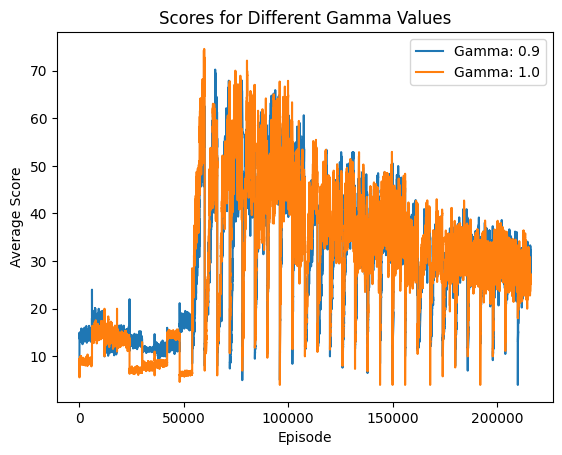

In [196]:
# Create a dictionary to store the scores for each alpha
gamma_scores = {}
for gamma in gamma_values:
    gamma_scores[gamma] = []
    for epsilon in epsilon_values:
        for alpha in alpha_values:
            for lambda_ in lambda_values:
                gamma_scores[gamma].extend(parameters_scores[epsilon][alpha][lambda_][gamma])

# Plot the scores for each alpha
for gamma, scores in gamma_scores.items():
    plt.plot(scores, label=f'Gamma: {gamma}')

# Add labels and title to the plot
plt.xlabel('Episode')
plt.ylabel('Average Score')
plt.title('Scores for Different Gamma Values')

# Add legend to the plot
plt.legend()

# Show the plot
plt.show()


$\gamma = 1$ seems to be the best choice for the discount factor.

Episode 100	Average Score: 12.11
Episode 200	Average Score: 15.07
Episode 300	Average Score: 13.98
Episode 400	Average Score: 14.38
Episode 500	Average Score: 15.85
Episode 600	Average Score: 16.05
Episode 700	Average Score: 18.02
Episode 800	Average Score: 17.63
Episode 900	Average Score: 20.89
Episode 1000	Average Score: 18.68
Episode 1100	Average Score: 21.43
Episode 1200	Average Score: 25.82
Episode 1300	Average Score: 27.46
Episode 1400	Average Score: 33.93
Episode 1500	Average Score: 40.97
Episode 1600	Average Score: 40.67
Episode 1700	Average Score: 37.40
Episode 1800	Average Score: 36.90
Episode 1900	Average Score: 41.17
Episode 2000	Average Score: 40.92
Episode 2100	Average Score: 36.80
Episode 2200	Average Score: 40.82
Episode 2300	Average Score: 43.00
Episode 2400	Average Score: 39.96
Episode 2500	Average Score: 51.46
Episode 2600	Average Score: 46.71
Episode 2700	Average Score: 55.23
Episode 2800	Average Score: 57.29
Episode 2900	Average Score: 52.48
Episode 3000	Average Sc

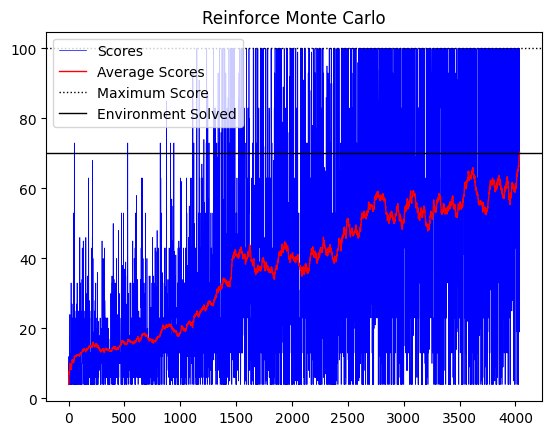

In [226]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
sarsa_lambda_agent = SarsaLambda(device, epsilon=0.1, alpha=0.1, lambda_=0.7, gamma=1.0)
scores, mean_scores = sarsa_lambda(sarsa_lambda_agent, env, n_episodes=6000, display=True)
# Plotting scores
plt.plot(scores, color='blue', linewidth=0.5, label='Scores')
plt.plot(mean_scores, color='red', linewidth=1, label='Average Scores')
plt.axhline(y=100, color='black', linestyle='dotted', linewidth=1, label='Maximum Score')
plt.axhline(y=70, color='black', linewidth=1, label='Environment Solved')
plt.legend()
plt.title('Reinforce Monte Carlo')
plt.show()
env.close()

Let's see how well the agent performs in the conditions it was trained in and in new conditions.

In [229]:
import gymnasium as gym
from tqdm import tqdm

# Define the different sets of parameters
parameters = [
    {'height': 15, 'width': 20, 'pipe_gap': 4},
    {'height': 10, 'width': 15, 'pipe_gap': 4},
    {'height': 15, 'width': 20, 'pipe_gap': 3},
    {'height': 10, 'width': 15, 'pipe_gap': 3},
    {'height': 15, 'width': 20, 'pipe_gap': 5},
    {'height': 10, 'width': 15, 'pipe_gap': 5}
    # Add more sets of parameters as needed
]
n_runs = 50
max_t = 2000

# Iterate over the sets of parameters
for params in parameters:
    # initiate environment
    env = gym.make('TextFlappyBird-v0', height=params['height'], width=params['width'], pipe_gap=params['pipe_gap'])
    total_reward = 0

    # Run 50 episodes
    for episode in tqdm(range(n_runs)):
        state, _ = env.reset()
        reward_sum = 0

        # iterate
        while True and reward_sum<max_t:
            # Select next action
            action = sarsa_lambda_agent.act(state, e=5000)

            # Apply action and return new observation of the environment
            state, reward, done, _, _ = env.step(action)
            reward_sum += reward

            # If player is dead, break
            if done:
                break

        total_reward += reward_sum

    # Calculate the average reward
    average_reward = total_reward / n_runs

    # Print the average reward for the current set of parameters
    print(f"Average reward for height={params['height']}, width={params['width']}, pipe_gap={params['pipe_gap']}: {average_reward}")


100%|██████████| 50/50 [00:01<00:00, 28.98it/s]


Average reward for height=15, width=20, pipe_gap=4: 650.98


100%|██████████| 50/50 [00:00<00:00, 114.32it/s]


Average reward for height=10, width=15, pipe_gap=4: 156.4


100%|██████████| 50/50 [00:00<00:00, 602.90it/s]


Average reward for height=15, width=20, pipe_gap=3: 21.12


100%|██████████| 50/50 [00:00<00:00, 653.31it/s]


Average reward for height=10, width=15, pipe_gap=3: 27.04


100%|██████████| 50/50 [00:04<00:00, 10.07it/s]


Average reward for height=15, width=20, pipe_gap=5: 1880.24


100%|██████████| 50/50 [00:04<00:00, 10.16it/s]

Average reward for height=10, width=15, pipe_gap=5: 2000.0


Due to the implementation of the Q_value table, the agent cannot perform in wider sight conditions. However, we notice the same differences in performance between the different conditions as the ones observed in the Reinforce Monte Carlo algorithm. That said, the Sarsa agent performs way better in favorable conditions than the Reinforce one and slightly poorer in unfavorable conditions.

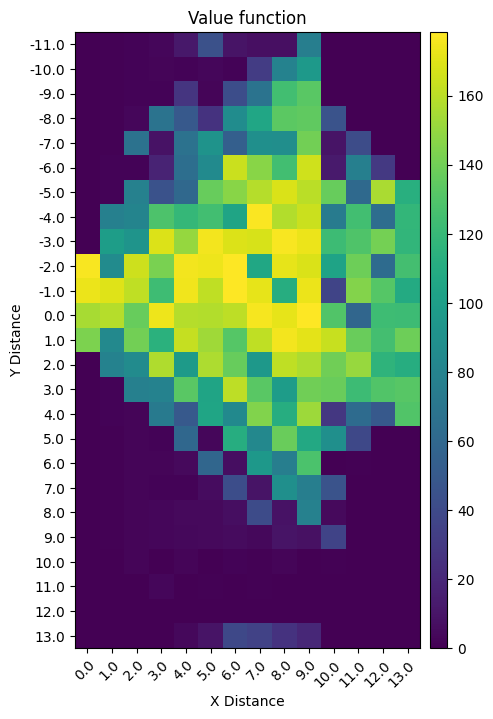

In [266]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

policy = sarsa_lambda_agent.Q

x_range = np.linspace(start=0, stop=13, num=14)
y_range = np.linspace(start=-11, stop=13, num=25)
X, Y = np.meshgrid(x_range, y_range)
Z = np.array([[sum(policy[int(x)][int(y+11)]) for x in x_range] for y in y_range])

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(Z, cmap='viridis')

# Create colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)

# Set ticks and labels for x-axis and y-axis
ax.set_xticks(np.arange(len(x_range)))
ax.set_yticks(np.arange(len(y_range)))
ax.set_xticklabels(x_range)
ax.set_yticklabels(y_range)

# Set labels for x-axis and y-axis
ax.set_xlabel('X Distance')
ax.set_ylabel('Y Distance')

# Set title for the plot
ax.set_title('Value function')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Show the plot
plt.show()


We first observe a diagonal of good situations, states that we aim to reach: from (0,-2) and (0,-1) (which is logic as it means the closest pipe is directly 2 pixels under or above the bird) to (9,9). This diagonal comes from the shape of the jump of the bird. Under this diagonal, the bird will not be able to reach the gap between the pipes.

Second, the center of the screen seem to be a good position when pipes are coming to the bird. Indeed, waiting in the middle allows a better adaptability to the next gap position. 

Let's check the stability of the agent by running the training on 50 episodes.

In [212]:
from tqdm import tqdm
scores = []
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for i in tqdm(range(50)):
    sarsa_lambda_agent = SarsaLambda(device, epsilon=0.1, alpha=0.1, lambda_=0.7, gamma=1.0)
    _, mean_scores = sarsa_lambda(sarsa_lambda_agent, env, n_episodes=2000, display=False, threshold=50.0)
    scores.append(mean_scores[-1])
env.close()


100%|██████████| 50/50 [01:35<00:00,  1.92s/it]


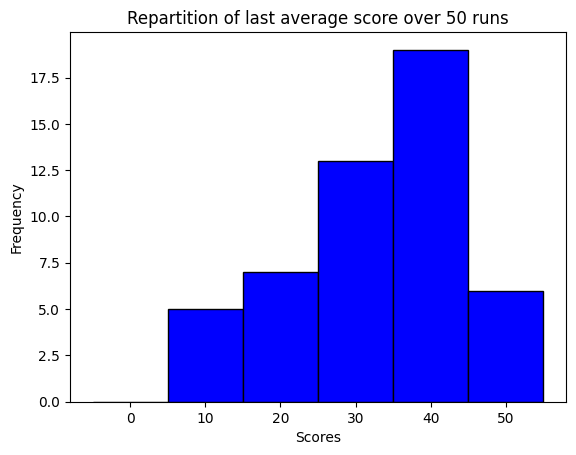

In [213]:
# Plotting scores
plt.hist(scores, bins=range(-5, 60, 10), color='blue', edgecolor='black')
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Repartition of last average score over 50 runs')
plt.show()

We get way more consistent results with SARSA($\lambda$) than with Reinforce Monte Carlo. The agent is able to learn how to play the game and to reach the end of the game in a consistent way.